In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# FOLDERS
# -----------------------------------------------------------------------------
data_folder = "data/daily"
average_output = "data/averages"
os.makedirs(average_output, exist_ok=True)



In [2]:
# -----------------------------------------------------------------------------
# LOAD DAILY FILES
# -----------------------------------------------------------------------------
files = sorted([f for f in os.listdir(data_folder)
                if f.startswith("hot_stocks") and f.endswith(".csv")])

print("Found files:")
for f in files:
    print(" -", f)

if not files:
    raise ValueError("⚠ No daily hot stocks files found in data/daily/. Cannot compute averages.")

all_days = []

for f in files:
    # extract YYYYMMDD
    date = f.split("_")[-1].replace(".csv", "")
    df = pd.read_csv(os.path.join(data_folder, f))
    df["date"] = pd.to_datetime(date, format="%Y%m%d%H%M%S")
    all_days.append(df)

full_df = pd.concat(all_days, ignore_index=True)
print("Loaded rows:", len(full_df))
display(full_df.head())


Found files:
 - hot_stocks_20251115174433.csv
 - hot_stocks_20251117182242.csv
 - hot_stocks_20251117215705.csv
 - hot_stocks_20251117220812.csv
 - hot_stocks_20251118083059.csv
 - hot_stocks_20251118133929.csv
 - hot_stocks_20251118140312.csv
 - hot_stocks_20251118154352.csv
 - hot_stocks_20251118163752.csv
 - hot_stocks_20251118172444.csv
 - hot_stocks_20251118173902.csv
 - hot_stocks_20251118213253.csv
 - hot_stocks_20251118214912.csv
 - hot_stocks_20251118220120.csv
 - hot_stocks_20251119085404.csv
Loaded rows: 750


,symbol,regularMarketPrice,regularMarketChangePercent,regularMarketVolume,averageDailyVolume3Month,marketCap,VolumeSpike,MomentumScore,VolumeScore,VolatilityScore,TrendScore,HotScore,date
0,CDTX,217.71,105.40600,17287415.0,872168.0,6.844666e+09,19.821198,1.000000,1.000000,1.000000,0.971787,0.997179,2025-11-15 17:44:33
1,SRRK,37.41,24.40970,6996750.0,2528325.0,3.596121e+09,2.767346,0.996865,0.962382,0.949843,0.761755,0.951881,2025-11-15 17:44:33
2,ABVX,110.39,9.40535,2409287.0,1075398.0,8.591534e+09,2.240368,0.968652,0.924765,0.968652,0.943574,0.950784,2025-11-15 17:44:33
3,LGN,40.27,20.85830,2813196.0,1162546.0,3.504975e+09,2.419858,0.990596,0.934169,0.940439,0.874608,0.949216,2025-11-15 17:44:33
4,DASH,206.96,6.01916,11452141.0,3701549.0,8.413522e+10,3.093878,0.921630,0.968652,0.981191,0.912226,0.949060,2025-11-15 17:44:33


In [3]:

# -----------------------------------------------------------------------------
# METRICS TO AVERAGE
# -----------------------------------------------------------------------------
metrics = [
    "HotScore",
    "regularMarketChangePercent",
    "VolumeSpike",
    "MomentumScore",
    "VolumeScore",
    "VolatilityScore",
    "TrendScore"
]

# ensure missing columns don't break code
metrics = [m for m in metrics if m in full_df.columns]

# -----------------------------------------------------------------------------
# COMPUTE AVERAGES
# -----------------------------------------------------------------------------
avg_df = (
    full_df.groupby("symbol")[metrics]
           .mean()
           .sort_values("HotScore", ascending=False)
)

display(avg_df.head(20))


,HotScore,regularMarketChangePercent,VolumeSpike,MomentumScore,VolumeScore,VolatilityScore,TrendScore
symbol,,,,,,,
CDTX,0.997179,105.406000,19.821198,1.000000,1.000000,1.000000,0.971787
NUVL,0.981277,12.032816,4.684670,0.985669,0.981489,0.974308,0.979101
PACS,0.964222,48.601135,11.303758,1.000000,0.996417,0.912742,0.829276
JAZZ,0.964211,12.319490,5.589532,0.941681,0.979355,0.969631,0.979220
SQM,0.956363,8.963033,3.970006,0.976080,0.974323,0.900824,0.935570
AVDL,0.939969,22.453200,4.832060,0.993730,0.990596,0.887147,0.680251
ASND,0.937223,6.188031,1.789729,0.941554,0.891879,0.982086,0.991044
CSIQ,0.934953,17.330500,3.216826,0.987461,0.971787,0.899687,0.692790
DGNX,0.923962,21.078302,2.302751,0.996030,0.943262,0.801982,0.848131


In [4]:

# Save to file
avg_csv = os.path.join(average_output, "average_hot_scores.csv")
avg_df.to_csv(avg_csv)
print(f"✅ Saved average results to {avg_csv}")


✅ Saved average results to data/averages\average_hot_scores.csv


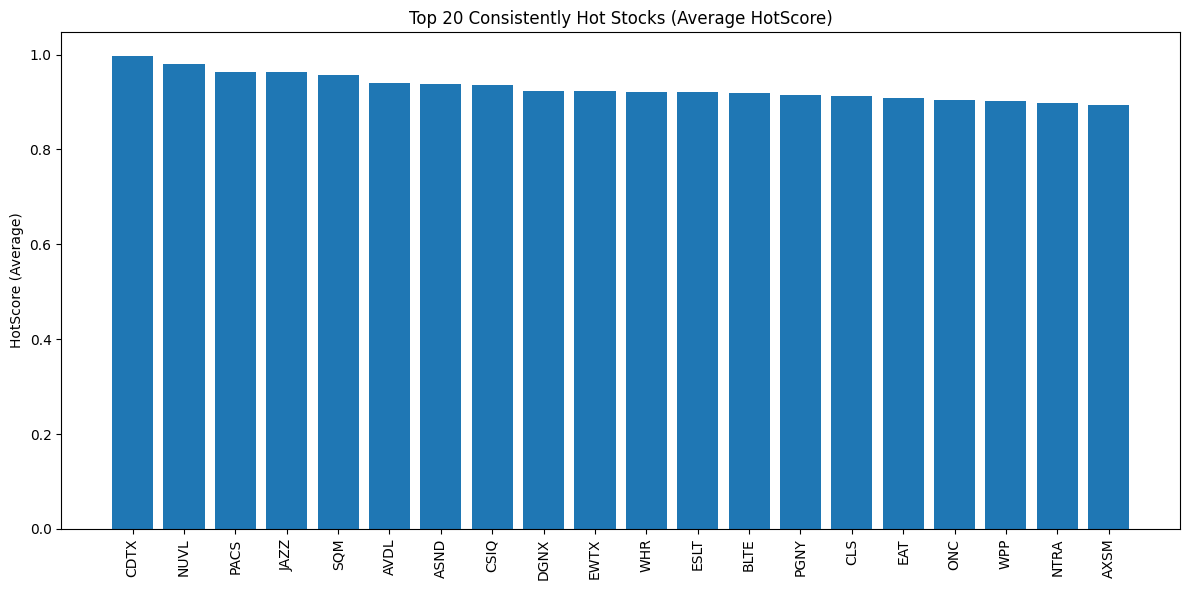

In [5]:

# -----------------------------------------------------------------------------
# TOP 20 CONSISTENT HOT STOCKS PLOT
# -----------------------------------------------------------------------------
top20 = avg_df.head(20)

plt.figure(figsize=(12,6))
plt.bar(top20.index, top20["HotScore"])
plt.xticks(rotation=90)
plt.title("Top 20 Consistently Hot Stocks (Average HotScore)")
plt.ylabel("HotScore (Average)")
plt.tight_layout()
plt.show()


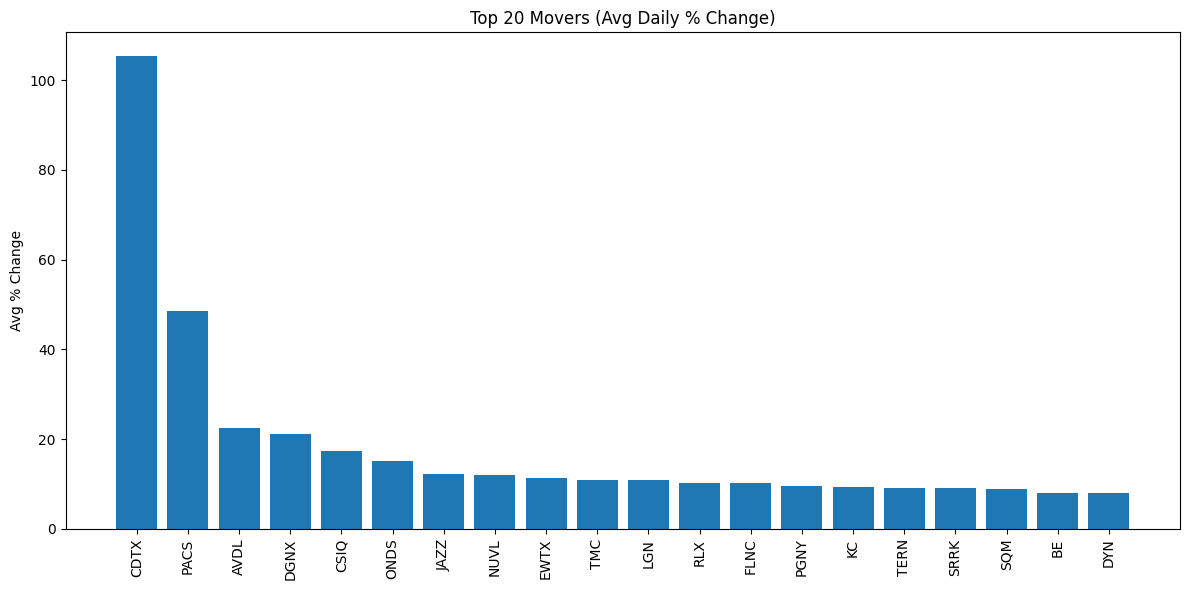

,Appearances,AvgHotScore
symbol,,
TERN,15,0.885597
DGNX,14,0.923962
LNW,14,0.826741
AS,14,0.820549
QUBT,14,0.769803
JAZZ,13,0.964211
NBIS,13,0.772279
CWAN,12,0.797605
ARQT,11,0.833893


In [6]:

# -----------------------------------------------------------------------------
# TOP 20 MOVERS (AVG % CHANGE)
# -----------------------------------------------------------------------------
if "regularMarketChangePercent" in avg_df.columns:
    top20_move = avg_df.sort_values("regularMarketChangePercent", ascending=False).head(20)

    plt.figure(figsize=(12,6))
    plt.bar(top20_move.index, top20_move["regularMarketChangePercent"])
    plt.xticks(rotation=90)
    plt.title("Top 20 Movers (Avg Daily % Change)")
    plt.ylabel("Avg % Change")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# PERSISTENT APPEARANCES
# -----------------------------------------------------------------------------
appearances = full_df["symbol"].value_counts()

persistent_df = (
    pd.DataFrame({
        "Appearances": appearances,
        "AvgHotScore": avg_df["HotScore"]
    })
    .sort_values(["Appearances", "AvgHotScore"], ascending=False)
)

display(persistent_df.head(20))




In [7]:


persistent_csv = os.path.join(average_output, "persistent_hot_stocks.csv")
persistent_df.to_csv(persistent_csv)
print(f"✅ Saved persistent list to {persistent_csv}")

✅ Saved persistent list to data/averages\persistent_hot_stocks.csv
